In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [137]:
def mode(x):
    return stats.mode(x)[0][0]

In [138]:
def etl_pipeline(df, is_train = False, create_interactions = False, fillna_dict = None,\
                 single_interaction_vars = None, higher_interaction_vars = None, df_grouping_train = None):
    df_etl = df.loc[:,:]
    if is_train == True:
        global_filter = (df_etl['return'] < 0.1) & (df_etl['pf_category'] != 'E') & (df_etl['type'] != 'G') & (df_etl['bought'] < 1e10)
        df_etl = df_etl.loc[global_filter, :]
    
    # encode basic variables
    df_etl['indicator_code'] = df_etl['indicator_code'].isnull().apply(lambda x: int(x))
    hedge_value_dict = {True:1, False:0}
    df_etl['hedge_value'] = df_etl['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)
    df_etl['has_desk_id'] = df_etl['desk_id'].isnull().apply(lambda x: int(x))
    
    # create new variables
    df_etl['has_hedge_value'] = df_etl['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
    df_etl['status'] = df_etl['status'].apply(lambda x: 1 if x == True else 0)
    df_etl['sell_year'] = df_etl['sell_date'].apply(lambda x: x//10000)
    df_etl['sell_month'] = df_etl['sell_date'].apply(lambda x: (x//100)%100)
    for col1, col2 in zip(['start_date', 'start_date', 'creation_date'], ['creation_date', 'sell_date', 'sell_date']):
        df_etl[col1 + '_' + col2] = df_etl.apply(lambda row: (datetime.strptime(str(row[col1]), '%Y%m%d') - \
                                                      datetime.strptime(str(row[col2]), '%Y%m%d')).days, axis = 1)
    df_etl['sold_bought'] = df_etl['sold'] - df_etl['bought']
    df_etl['libor_rate_missing'] = df_etl['libor_rate'].isnull().apply(lambda x: int(x))

    # fill missing values
    if fillna_dict is not None:
        df_etl.fillna(fillna_dict, inplace = True)
        
    df_etl['euribor_plus_libor'] = df_etl['euribor_rate'] + df_etl['libor_rate']
    df_etl['euribor_minus_libor'] = df_etl['euribor_rate'] - df_etl['libor_rate']
    
    if create_interactions == True and is_train == True:
        assert single_interaction_vars is not None and higher_interaction_vars is not None
        df_grouping = {}
        for var_to_group in single_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby([var_to_group])\
                                              .agg({'return':[np.mean, np.median, np.max, np.min, 'count', np.std, \
                                                              mode]})
            new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            # print (new_col_names)
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

        for var_to_group in higher_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby(list(var_to_group))\
                                          .agg({'return':[np.mean, np.median, np.max, np.min, 'count', np.std, \
                                                          mode]})
            new_col_names =  list(var_to_group) + ['_'.join(['_'.join(var_to_group)] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col[-6:]:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = list(var_to_group), how = 'left')
            
    if is_train == False and create_interactions == True:
        assert df_grouping_train is not None
        for var_to_group in df_grouping_train.keys():
            df_etl = pd.merge(left = df_etl, right = df_grouping_train[var_to_group], on = var_to_group, how = 'left')
        
    if is_train == True:
        if (len(df_grouping) > 0):
            return (df_etl, df_grouping)
    return (df_etl)
    

In [213]:
df = pd.read_csv('../inputs/train.csv')
fillna_dict = {'euribor_rate' : df['euribor_rate'].median(),
               'libor_rate' : df['libor_rate'].median(),
               'desk_id' : 'NA'}
single_interaction_vars = ['pf_category', 'country_code', 'type', 'indicator_code', 'hedge_value',\
                           'status', 'sell_year', 'sell_month']
higher_interaction_vars = [('office_id', 'country_code'), ('pf_category', 'type'), ('office_id', 'type'),\
                           ('office_id', 'pf_category'), ('country_code', 'pf_category')]

In [214]:
df, df_grouping_train = etl_pipeline(df, is_train = True, create_interactions = True, fillna_dict = fillna_dict,\
                                     single_interaction_vars = single_interaction_vars, \
                                     higher_interaction_vars = higher_interaction_vars)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

pf_category
country_code
type
indicator_code
hedge_value
status
sell_year
sell_month
('office_id', 'country_code')
('pf_category', 'type')
('office_id', 'type')
('office_id', 'pf_category')
('country_code', 'pf_category')


In [215]:
print (df.dtypes)

portfolio_id                               object
desk_id                                    object
office_id                                  object
pf_category                                object
start_date                                  int64
sold                                      float64
country_code                               object
euribor_rate                              float64
currency                                   object
libor_rate                                float64
bought                                    float64
creation_date                               int64
indicator_code                              int64
sell_date                                   int64
type                                       object
hedge_value                                 int64
status                                      int64
return                                    float64
has_desk_id                                 int64
has_hedge_value                             int64


In [216]:
input_cols_xgb_encode = ['office_id', 'pf_category', 'country_code', 'type'] 
input_cols_xgb_numeric = df.dtypes[(df.dtypes == np.int64) | (df.dtypes == np.float64)].index.tolist()
# print (input_cols_xgb_numeric)
input_cols_xgb_numeric.remove('return')
target_cols_xgb = ['return']

In [217]:
# remove low feature importance columns
low_importance_cols = ['hedge_value_return_count','status_return_amax','status_return_amin','status_return_count','hedge_value_return_amax','indicator_code_return_amin','has_hedge_value','has_desk_id','indicator_code_return_amax','indicator_code_return_median','hedge_value','hedge_value_return_amin','indicator_code_return_count']
low_importance_cols2 = ['type_return_count','pf_category_return_amin','hedge_value_return_mean','country_code_return_count','indicator_code_return_mean','pf_category_return_count','status_return_median','hedge_value_return_median']
low_importance_cols3 = ['country_code_pf_category_return_median','country_code_pf_category_return_amin','status_return_std','office_id_pf_category_return_median','office_id_pf_category_return_mean','office_id_type_return_median','pf_category_return_std','hedge_value_return_median','hedge_value_return_std','libor_rate_missing', 'type_return_std']
low_importance_cols4 = ['country_code_pf_category_return_mean','office_id_country_code_return_mode','office_id_pf_category_return_mode','office_id_pf_category_return_amin','pf_category_return_median','country_code_pf_category_return_mode']
low_importance_cols5 = ['country_code_pf_category_return_amax','office_id_type_return_std','office_id_type_return_mode','country_code_return_amax','office_id_type_return_count','office_id_type_return_amax','office_id_type_return_mean',\
                        'pf_category_type_return_mode','office_id_country_code_return_median','status_return_mode','country_code_return_mode','country_code_pf_category_return_std','indicator_code_return_mode', 'office_id_pf_category_return_std',\
                        'type_return_mode']
date_cols = ['sell_date', 'creation_date', 'start_date']
different_dist_cols = []
for col in list(low_importance_cols + low_importance_cols2 + low_importance_cols3 + \
                low_importance_cols4 + low_importance_cols5 + date_cols + different_dist_cols):
    if col in input_cols_xgb_encode:
        input_cols_xgb_encode.remove(col)
    if col in input_cols_xgb_numeric:
        input_cols_xgb_numeric.remove(col)
        
print (input_cols_xgb_numeric)

['sold', 'euribor_rate', 'libor_rate', 'bought', 'indicator_code', 'status', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'euribor_plus_libor', 'euribor_minus_libor', 'pf_category_return_mean', 'pf_category_return_amax', 'pf_category_return_mode', 'country_code_return_mean', 'country_code_return_median', 'country_code_return_amin', 'country_code_return_std', 'type_return_mean', 'type_return_median', 'type_return_amax', 'type_return_amin', 'indicator_code_return_std', 'hedge_value_return_mode', 'status_return_mean', 'sell_year_return_mean', 'sell_year_return_median', 'sell_year_return_amax', 'sell_year_return_amin', 'sell_year_return_count', 'sell_year_return_std', 'sell_year_return_mode', 'sell_month_return_mean', 'sell_month_return_median', 'sell_month_return_amax', 'sell_month_return_amin', 'sell_month_return_count', 'sell_month_return_std', 'sell_month_return_mode', 'office_id_country_code_return_mean', 'off

In [218]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    print (input_cols_xgb_encode[i])
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix()

office_id
pf_category
country_code
type


In [14]:
# xgboost parameter tuning

In [145]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [10, 50, 100, 150, 200, 250, 500]}
xgb_reg = XGBRegressor(random_state=42)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'n_estimators': 200}


In [146]:
pd.DataFrame(clf.cv_results_)
# take 200 trees as the optimum number for now

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.152506,0.007324,-421.786478,-101.198969,10,{'n_estimators': 10},7,-49.415194,-164.055446,-92.980556,-77.328209,-1123.188565,-62.213252,0.001081,0.000473,496.205537,44.872545
1,0.516007,0.011206,0.465873,0.946658,50,{'n_estimators': 50},6,0.161357,0.943568,0.944774,0.943274,0.291432,0.953131,0.006781,0.003135,0.342799,0.004579
2,1.104769,0.014562,0.508388,0.977833,100,{'n_estimators': 100},3,0.128891,0.988984,0.971877,0.970779,0.424370,0.973735,0.149828,0.001807,0.349254,0.007977
3,1.731510,0.018692,0.507759,0.981497,150,{'n_estimators': 150},4,0.121526,0.991464,0.973371,0.975770,0.428356,0.977258,0.048322,0.003777,0.352284,0.007073
4,2.534286,0.023900,0.513199,0.984065,200,{'n_estimators': 200},1,0.125635,0.992826,0.974348,0.979369,0.439589,0.980000,0.628257,0.006700,0.350391,0.006200
5,3.250807,0.030562,0.510714,0.985931,250,{'n_estimators': 250},2,0.114636,0.993782,0.974736,0.981884,0.442747,0.982128,0.294312,0.006980,0.354426,0.005552
6,6.324103,0.055135,0.495547,0.991514,500,{'n_estimators': 500},5,0.072720,0.996450,0.976013,0.988677,0.437890,0.989414,0.578921,0.002474,0.371034,0.003503


In [147]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 7, 'min_child_weight': 5}


In [148]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.554615,0.027573,0.513199,0.984065,3,1,"{'max_depth': 3, 'min_child_weight': 1}",9,0.125635,0.992826,0.974348,0.979369,0.439589,0.980000,0.335005,0.002490,0.350391,0.006200
1,2.530009,0.023895,0.518961,0.983537,3,3,"{'max_depth': 3, 'min_child_weight': 3}",8,0.162230,0.991913,0.974828,0.978990,0.419793,0.979706,0.074602,0.002051,0.339087,0.005930
2,2.471191,0.026560,0.525045,0.983028,3,5,"{'max_depth': 3, 'min_child_weight': 5}",7,0.196334,0.991394,0.975378,0.978742,0.403385,0.978947,0.012214,0.005418,0.329485,0.005916
3,3.891168,0.033913,0.364224,0.995867,5,1,"{'max_depth': 5, 'min_child_weight': 1}",10,0.080805,0.998360,0.975548,0.994934,0.036214,0.994308,0.209766,0.002114,0.432689,0.001781
4,3.767705,0.034416,0.604607,0.995079,5,3,"{'max_depth': 5, 'min_child_weight': 3}",2,0.348705,0.997612,0.973058,0.994140,0.492024,0.993484,0.313332,0.002478,0.267043,0.001811
5,3.648433,0.032909,0.588186,0.994298,5,5,"{'max_depth': 5, 'min_child_weight': 5}",5,0.282661,0.997166,0.971754,0.993073,0.510118,0.992654,0.278459,0.003932,0.286699,0.002036
6,4.040996,0.038249,0.304830,0.998495,7,1,"{'max_depth': 7, 'min_child_weight': 1}",11,0.157827,0.998808,0.969686,0.998330,-0.213188,0.998347,0.951713,0.007865,0.493956,0.000221
7,4.309067,0.039929,0.585475,0.997680,7,3,"{'max_depth': 7, 'min_child_weight': 3}",6,0.263087,0.998369,0.963760,0.997029,0.529561,0.997642,0.876797,0.009094,0.288783,0.000548
8,4.500062,0.042602,0.610904,0.997224,7,5,"{'max_depth': 7, 'min_child_weight': 5}",1,0.329777,0.997605,0.970700,0.997047,0.532209,0.997020,0.916129,0.012050,0.267519,0.000270
9,3.776537,0.031919,0.107637,0.998961,9,1,"{'max_depth': 9, 'min_child_weight': 1}",12,0.168624,0.999155,0.970873,0.998866,-0.816884,0.998863,0.482425,0.006817,0.731102,0.000137


In [149]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[6, 7, 8],
 'min_child_weight':[4, 5, 6]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 7, 'min_child_weight': 4}


In [150]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.206386,0.040421,0.618881,0.996648,6,4,"{'max_depth': 6, 'min_child_weight': 4}",2,0.353063,0.997781,0.971277,0.996217,0.532274,0.995947,0.715462,0.009341,0.259719,0.000808
1,4.257480,0.039442,0.596659,0.996341,6,5,"{'max_depth': 6, 'min_child_weight': 5}",6,0.326319,0.997600,0.958895,0.996093,0.504732,0.995329,0.662690,0.004714,0.266314,0.000944
2,4.322036,0.039438,0.590938,0.995996,6,6,"{'max_depth': 6, 'min_child_weight': 6}",8,0.281680,0.997606,0.972097,0.995289,0.519013,0.995094,0.515654,0.006398,0.286426,0.001141
3,4.424123,0.037256,0.622360,0.997503,7,4,"{'max_depth': 7, 'min_child_weight': 4}",1,0.372244,0.997873,0.966358,0.997327,0.528448,0.997310,0.878054,0.008644,0.251482,0.000261
4,4.512301,0.039439,0.610904,0.997224,7,5,"{'max_depth': 7, 'min_child_weight': 5}",4,0.329777,0.997605,0.970700,0.997047,0.532209,0.997020,0.922927,0.007898,0.267519,0.000270
5,4.662264,0.040597,0.591389,0.996871,7,6,"{'max_depth': 7, 'min_child_weight': 6}",7,0.269275,0.997308,0.976025,0.996688,0.528849,0.996616,0.997618,0.008511,0.291913,0.000310
6,4.405416,0.039919,0.609963,0.997754,8,4,"{'max_depth': 8, 'min_child_weight': 4}",5,0.353969,0.998006,0.976516,0.997643,0.499368,0.997614,0.857173,0.009500,0.265922,0.000179
7,4.521931,0.039267,0.612232,0.997541,8,5,"{'max_depth': 8, 'min_child_weight': 5}",3,0.338256,0.997747,0.972090,0.997376,0.526322,0.997500,0.797235,0.006142,0.265808,0.000154
8,4.696681,0.042257,0.579557,0.997349,8,6,"{'max_depth': 8, 'min_child_weight': 6}",9,0.236179,0.997491,0.973158,0.997305,0.529317,0.997251,1.097070,0.009003,0.302975,0.000103


In [151]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 7, min_child_weight = 4)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'gamma': 0.0}


In [152]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.778039,0.031751,0.622360,0.997503,0,{'gamma': 0.0},1,0.372244,0.997873,0.966358,0.997327,0.528448,0.997310,0.903659,0.006865,0.251482,0.000261
1,5.279512,0.009358,-0.114715,0.826081,0.1,{'gamma': 0.1},2,-0.565396,0.799552,0.823789,0.821496,-0.602695,0.857195,1.070684,0.000236,0.663850,0.023755
2,6.400912,0.014374,-0.362070,0.750864,0.2,{'gamma': 0.2},3,-0.564859,0.724086,0.636113,0.736734,-1.157719,0.791770,1.322904,0.003715,0.746218,0.029383
3,5.482779,0.010023,-0.612325,0.663541,0.3,{'gamma': 0.3},4,-0.571738,0.639021,0.478745,0.640926,-1.744346,0.710675,0.805824,0.001080,0.908003,0.033338
4,5.254625,0.009513,-0.795351,0.600293,0.4,{'gamma': 0.4},5,-0.578927,0.580078,0.324864,0.556405,-2.132418,0.664396,0.406058,0.001422,1.014762,0.046346
5,4.993629,0.011698,-1.086898,0.510328,0.5,{'gamma': 0.5},6,-0.589876,0.507629,0.059765,0.445104,-2.731111,0.578251,0.109517,0.002394,1.192322,0.054390


In [153]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 7, min_child_weight = 4, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 1.0, 'subsample': 1.0}


In [154]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.070845,0.041167,0.594133,0.997595,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",8,0.258403,0.998504,0.973150,0.997344,0.550831,0.996938,0.217249,0.006173,0.293411,0.000664
1,4.073129,0.040784,0.557347,0.997684,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",19,0.193078,0.998435,0.973433,0.997464,0.505513,0.997152,0.162856,0.005528,0.320696,0.000546
2,4.186868,0.046458,0.596762,0.997918,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",5,0.271701,0.998556,0.975702,0.997898,0.542865,0.997299,1.012561,0.004342,0.289937,0.000513
3,3.078877,0.039116,0.595568,0.997875,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",6,0.365555,0.998383,0.972124,0.997775,0.448977,0.997468,0.445876,0.005551,0.268456,0.000380
4,2.502378,0.034925,0.520136,0.997333,0.6,1,"{'colsample_bytree': 0.6, 'subsample': 1.0}",25,0.137654,0.997625,0.975441,0.997124,0.447290,0.997250,0.428508,0.003868,0.345899,0.000213
5,4.989993,0.044113,0.569305,0.997663,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",17,0.209793,0.998520,0.979006,0.997485,0.519101,0.996985,0.394300,0.006431,0.316046,0.000639
6,4.529130,0.038937,0.565492,0.997913,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",18,0.196500,0.998552,0.968861,0.997750,0.531104,0.997437,0.406000,0.005992,0.316268,0.000470
7,4.093902,0.041088,0.601586,0.997980,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",4,0.329702,0.998486,0.977596,0.997923,0.497427,0.997533,0.416273,0.006443,0.274575,0.000391
8,3.549119,0.042926,0.608118,0.997989,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",2,0.317529,0.998430,0.977976,0.997990,0.528823,0.997548,0.509407,0.002487,0.275407,0.000360
9,2.798437,0.033420,0.592313,0.997473,0.7,1,"{'colsample_bytree': 0.7, 'subsample': 1.0}",9,0.313381,0.997977,0.976030,0.997040,0.487493,0.997402,0.490592,0.006998,0.280506,0.000386


In [158]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'colsample_bytree':[0.95, 1],
 'subsample':[0.95, 1.0]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 7, min_child_weight = 4, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 1, 'subsample': 1.0}


In [159]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.148436,0.040137,0.591548,0.997923,0.95,0.95,"{'colsample_bytree': 0.95, 'subsample': 0.95}",4,0.281452,0.998333,0.973464,0.997826,0.519705,0.997611,0.879682,0.019787,0.287057,0.000303
1,3.952317,0.034102,0.599030,0.997503,0.95,1,"{'colsample_bytree': 0.95, 'subsample': 1.0}",3,0.335381,0.997868,0.971741,0.997151,0.489932,0.997492,0.826443,0.007262,0.271014,0.000293
2,4.748441,0.036749,0.620136,0.998092,1,0.95,"{'colsample_bytree': 1, 'subsample': 0.95}",2,0.374055,0.998375,0.972755,0.998005,0.513564,0.997898,0.711067,0.007278,0.255780,0.000204
3,3.900055,0.034082,0.622360,0.997503,1,1,"{'colsample_bytree': 1, 'subsample': 1.0}",1,0.372244,0.997873,0.966358,0.997327,0.528448,0.997310,0.803757,0.008530,0.251482,0.000261


In [160]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 7, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 1.0, subsample = 1.0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'reg_alpha': 0}


In [161]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_reg = XGBRegressor(random_state=42, n_estimators = 1000, \
                       max_depth = 7, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 1.0, subsample = 1.0, reg_alpha = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'learning_rate': 0.3}


In [228]:
# train the final classifier
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.3, n_estimators = 2000, \
                       max_depth = 7, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 1.0, subsample = 1.0, reg_alpha = 1e-5)
xgb_reg.fit(X_xgb, y_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [229]:
y_xgb_pred = xgb_reg.predict(X_xgb)
print (r2_score(y_xgb, y_xgb_pred))

0.997941496636


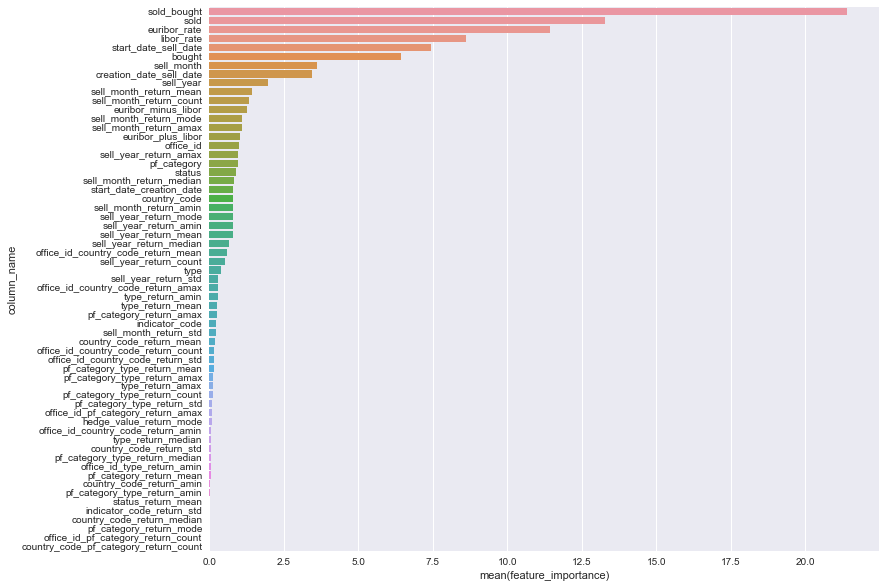

In [230]:
# plot the feature importances
df_feature_importance = pd.DataFrame(list(zip((input_cols_xgb_encode + input_cols_xgb_numeric), \
                                              xgb_reg.feature_importances_)),\
                                     columns = ['column_name', 'feature_importance'])
df_feature_importance = df_feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index()
df_feature_importance['feature_importance'] *= 100
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(12 , 10))
sns.barplot(x = 'feature_importance', y = 'column_name', data = df_feature_importance)

In [231]:
df_feature_importance

,index,column_name,feature_importance
0,15,sold_bought,21.405579
1,4,sold,13.277897
2,5,euribor_rate,11.427039
3,6,libor_rate,8.610515
4,13,start_date_sell_date,7.457081
5,7,bought,6.437768
6,11,sell_month,3.621245
7,14,creation_date_sell_date,3.460300
8,10,sell_year,1.958155
9,39,sell_month_return_mean,1.421674


In [232]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

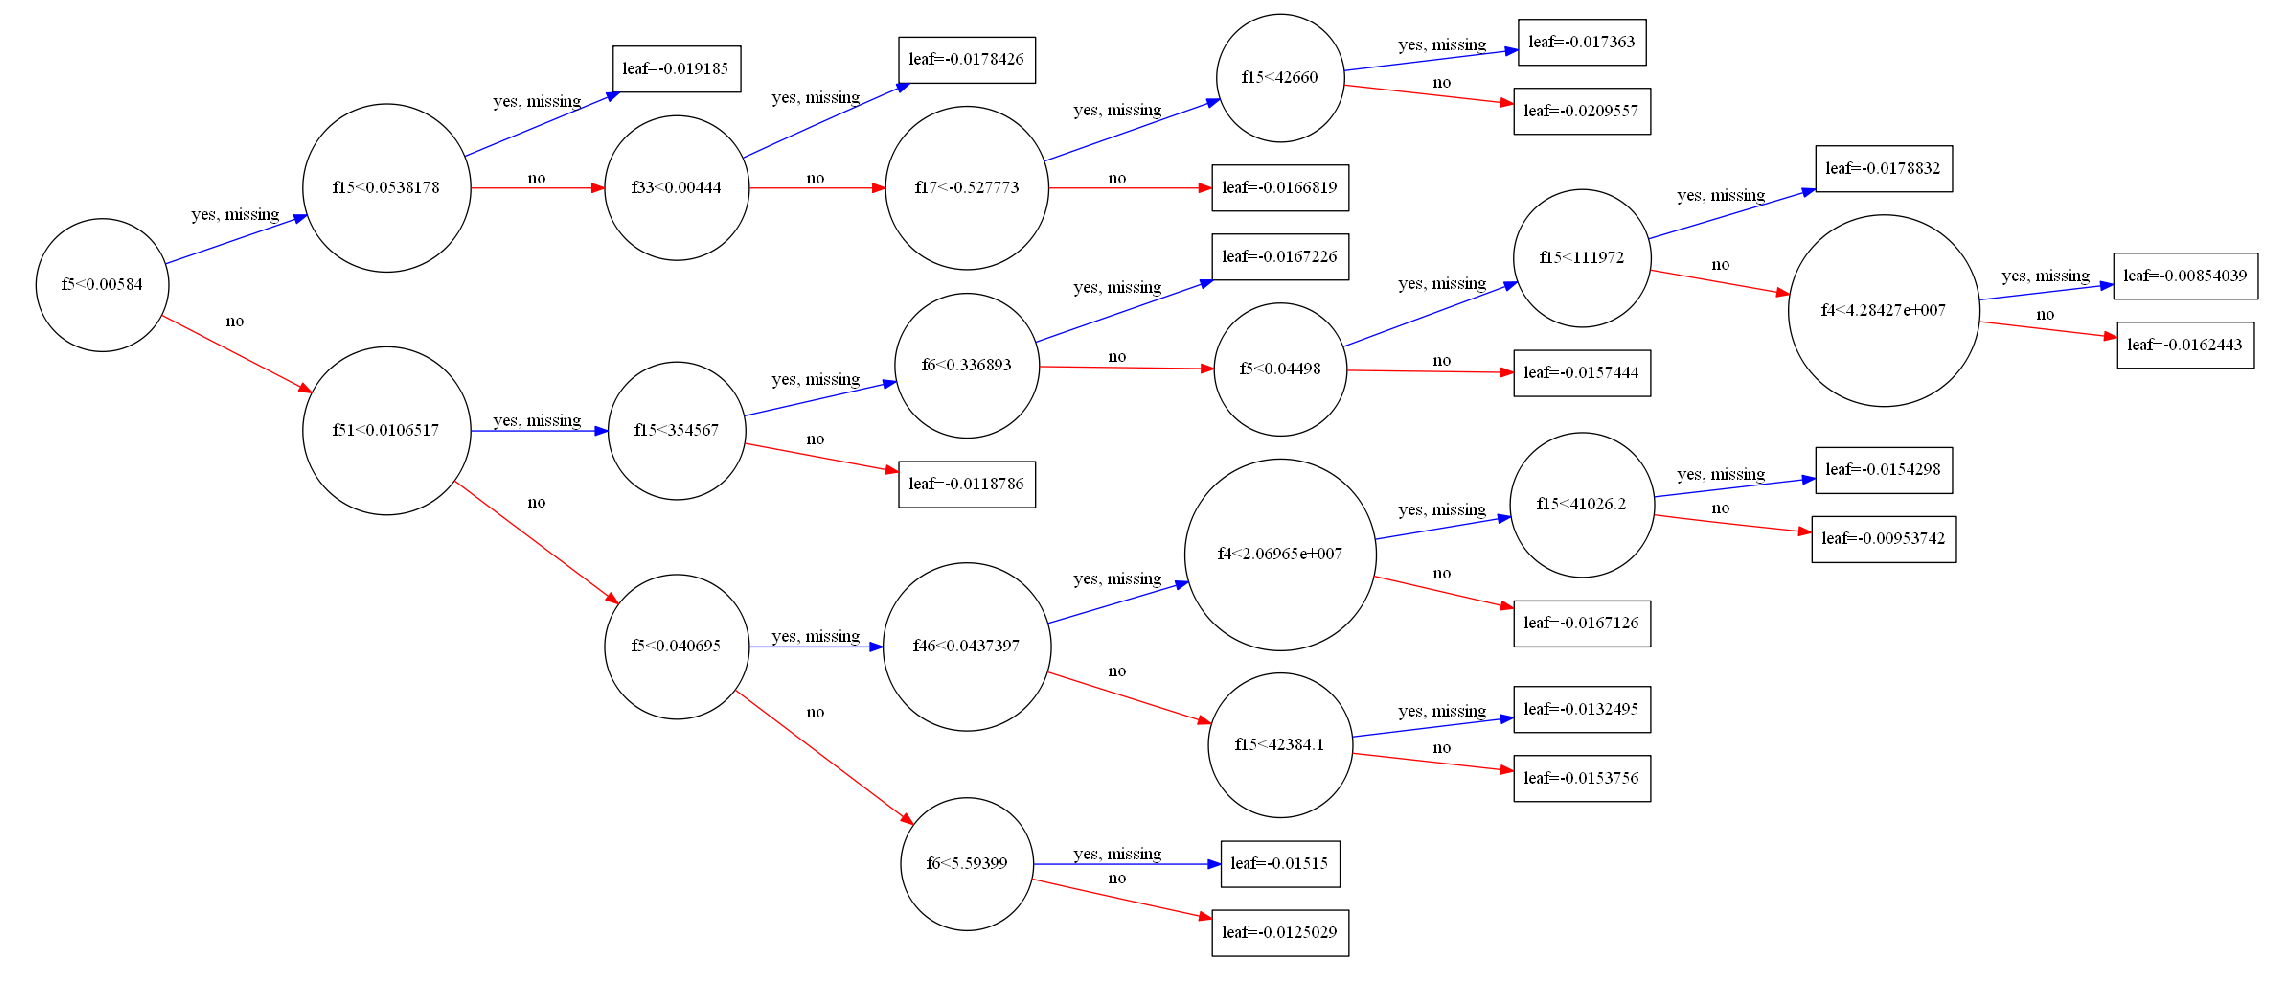

In [233]:
# plot the tree
fig, axs = plt.subplots(nrows = 1, figsize = (40, 20))
plot_tree(xgb_reg, num_trees = 6, rankdir = 'LR', ax = axs)

In [225]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

In [226]:
df_test = etl_pipeline(df_test, is_train=False, create_interactions=True, fillna_dict=fillna_dict,\
                      df_grouping_train=df_grouping_train)

In [234]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])

df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = xgb_reg.predict(X_xgb_test)

df_submit.to_csv('../submissions/submit_20171218_0443_xgb.csv', index=False)


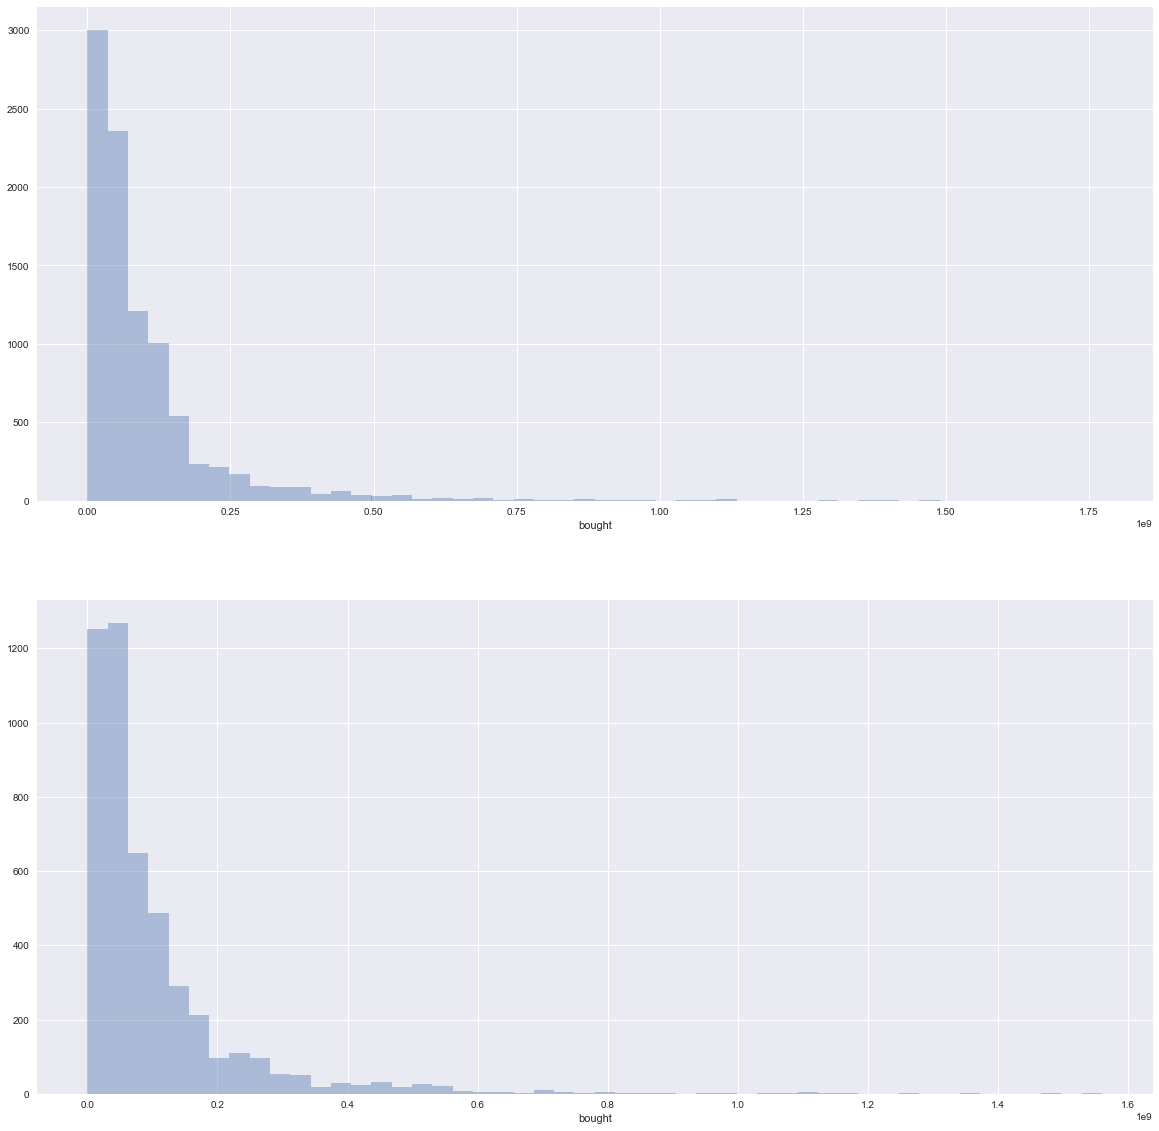

In [41]:
var = 'bought'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df.loc[df['sold_bought'] > -2.5e+5, var], ax = axs[0], kde=False)
sns.distplot(df_test[var], ax = axs[1], kde=False)

In [37]:
print (df['sold_bought'].sort_values().head(10))
print ((df['sold_bought']).describe())
print (df_test['sold_bought'].describe())

7466   -2.602705e+06
8034   -2.180339e+05
7464   -2.093125e+05
8647   -1.351810e+05
9103   -1.307788e+05
8872   -1.265971e+05
8085   -1.004125e+05
7689   -9.842410e+04
7648   -9.178789e+04
7779   -9.061993e+04
Name: sold_bought, dtype: float64
count    9.356000e+03
mean     8.227913e+04
std      2.576593e+05
min     -2.602705e+06
25%      1.805671e+03
50%      8.422815e+03
75%      3.915617e+04
max      3.229342e+06
Name: sold_bought, dtype: float64
count    4.801000e+03
mean     7.775883e+04
std      2.406707e+05
min     -1.952065e+05
25%      1.761696e+03
50%      7.333628e+03
75%      3.652275e+04
max      3.495974e+06
Name: sold_bought, dtype: float64


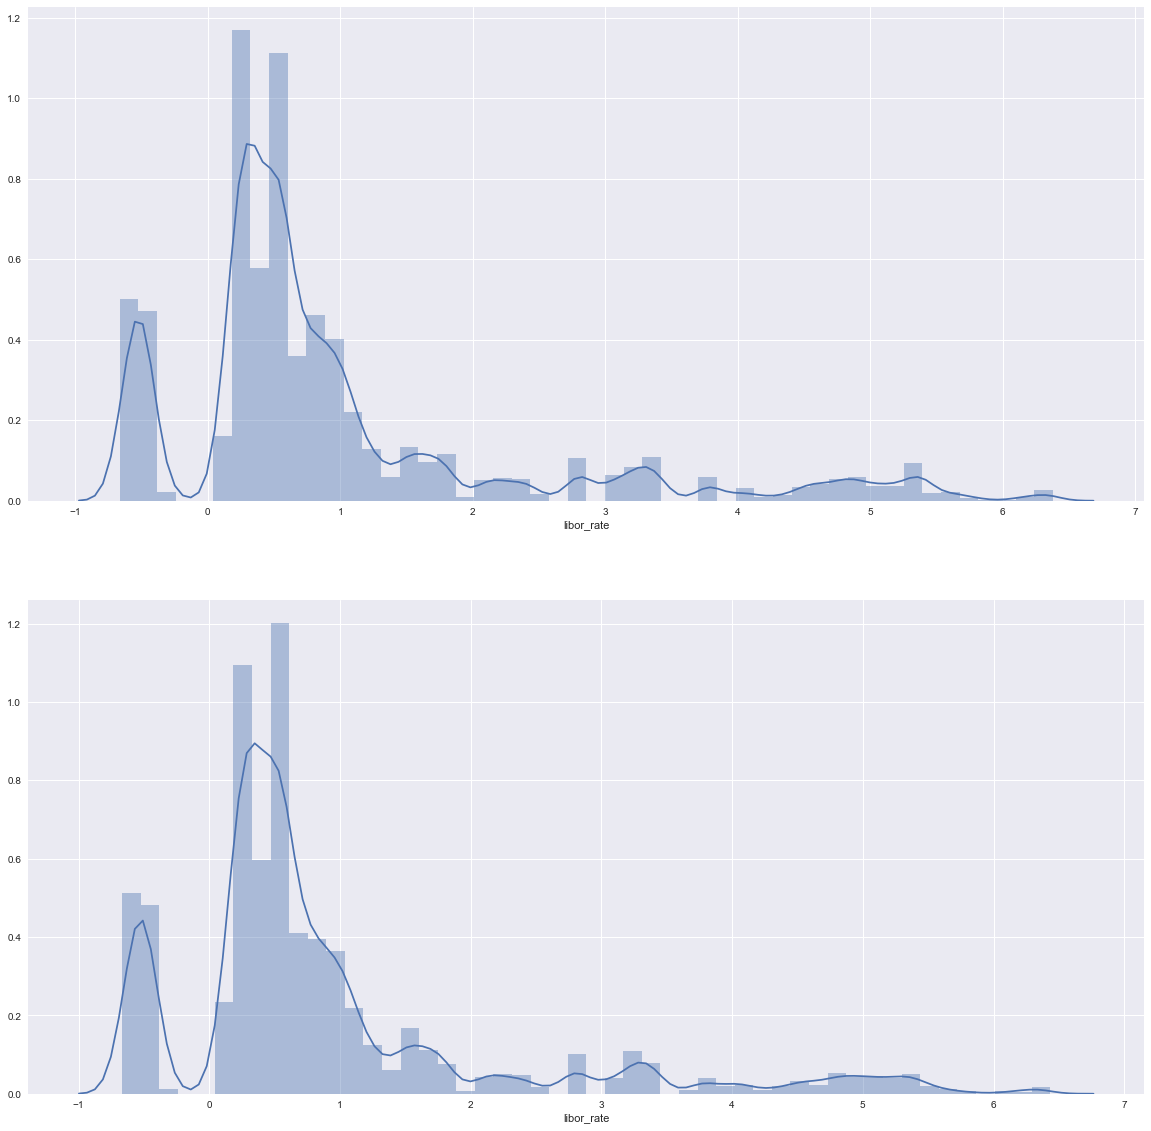

In [151]:
var = 'libor_rate'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df[var], ax = axs[0])
sns.distplot(df_test[var], ax = axs[1])

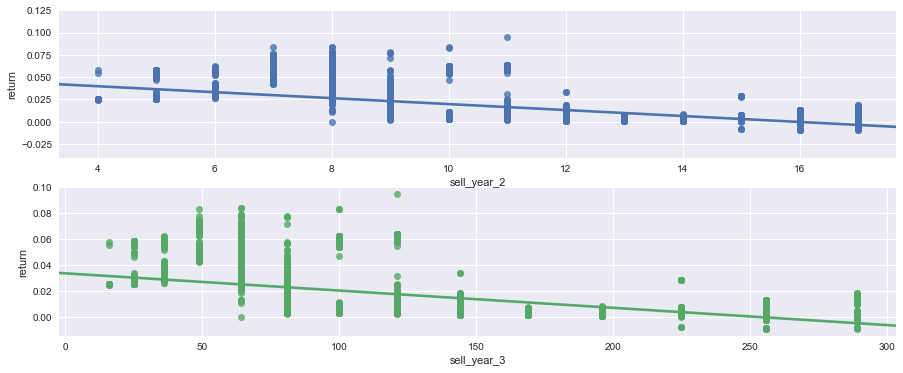

In [45]:
# understand the variation of returns with difference between sell year
variable_considered = 'sell_year'
variable_observed = 'return'
df['sell_year_2'] = df['sell_year'].apply(lambda x: x % 100)
df['sell_year_3'] = df['sell_year_2'].apply(lambda x: x ** 2) 
# fig, axs = plt.subplots(ncols = 3, figsize=(15, 6), gridspec_kw = {'width_ratios':[2, 0.5, 1]})
fig, axs = plt.subplots(nrows = 2, figsize=(15, 6))
sns.regplot(x = 'sell_year_2', y = variable_observed, data = df, ax = axs[0])
sns.regplot(x = 'sell_year_3', y = variable_observed, data = df, ax = axs[1])
# sns.boxplot(y = variable_observed, data = df.loc[filter_condition, :], ax = axs[1])
# sns.countplot(x = variable_considered, data = df.loc[filter_condition, :], ax = axs[2])

In [61]:
for group in df.groupby(['office_id', 'type', 'country_code']):
    print (group[0])

('OFF00001001', 'A', 'T')
('OFF00001001', 'B', 'T')
('OFF00001001', 'C', 'N')
('OFF00001001', 'D', 'M')
('OFF00001001', 'E', 'M')
('OFF00001001', 'E', 'Z')
('OFF00001002', 'B', 'T')
('OFF00001002', 'C', 'N')
('OFF00001002', 'D', 'M')
('OFF00001002', 'E', 'M')
('OFF00001002', 'F', 'U')
('OFF00001002', 'H', 'Z')
